<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_9_cnn_part1/homework/hw_cnn_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1. Convolution

Implement a convolution function `conv(x, kernel, stride, pad)`, where:


* $\text{x}$: Two-dimensional array of size $(W,H)$;
* $\text{kernel}$: convolution kernel of size $(K, K)$;
* $\text{stride}$: convolution kernel stride. $0 < \text{stride} \leq \min(W,H)$;
* $\text{pad}$: padding width on each side of the array. $\text{pad} > 0$.

The result of the function is to return the following value:
* $out$: Result of convolution of input data $\text{x}$, having size $(H', W')$:
   - $H' = 1 + (H + 2 \cdot pad - K)\ //\ stride$;
   - $W' = 1 + (W + 2 \cdot pad - K)\ //\ stride$.

---

Use the created `conv`[Sobel operator](https://en.wikipedia.org/w%D0%B5%D0%BB%D1%8F)
to the image, and then display the result on the screen.

You can work with both `numpy` and `torch` as you wish.

In [1]:
import torch
import numpy as np
import torch.nn.functional as F


In [2]:
# Можете тренироваться на этом примере
a = np.arange(9).reshape((3, 3))
M = np.block([[a, a],[a, a]])
print(M)

[[0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]
 [0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]]


In [3]:
def conv(x, kernel, stride, pad):    
    H = x.shape[0]
    W = x.shape[1]
    
    # padding x
    x = torch.from_numpy(x)
    x = F.pad(x, pad=(pad, pad, pad, pad), mode='constant', value=0)
    
    # calculating sizes for convolution
    K = kernel.shape[0]
    H_conv = 1 + (H + 2 * pad - K) // stride
    W_conv = 1 + (W + 2 * pad - K) // stride
    x_conv = torch.zeros((H_conv, W_conv))
    
    # x convolution
    row, col = 0, 0
    while row < H - K:
        while col < W - K:
            x_conv[row // stride][col // stride] = (x[row:(row+K), col:(col+K)] * kernel).sum()
            col += stride
        col = 0
        row += stride
    return x_conv.numpy()

In [4]:
sobel_kernel_vert = torch.Tensor([
                                  [-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]
])


sobel_kernel_hor = torch.Tensor([
                                 [-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]
])

In [5]:
conv(M, sobel_kernel_vert, stride=1, pad=1)

array([[ 6.,  6., -3.,  0.,  0.,  0.],
       [16.,  8., -4.,  0.,  0.,  0.],
       [19.,  8., -4.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

Apply these two filters to the following picture and draw the results:

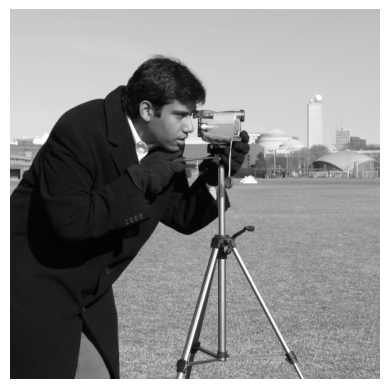

In [6]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

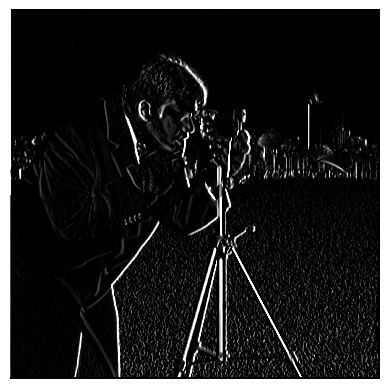

In [7]:
camera_conv = conv(camera, sobel_kernel_vert, stride=1, pad=1)
plt.figure()
plt.imshow(camera_conv.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

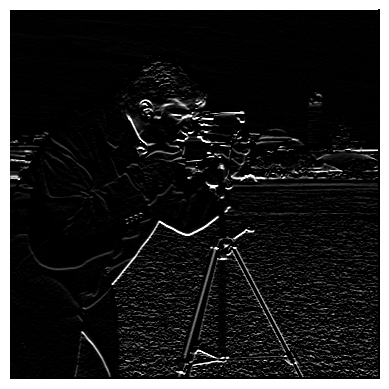

In [8]:
camera_conv = conv(camera, sobel_kernel_hor, stride=1, pad=1)
plt.figure()
plt.imshow(camera_conv.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

Add the code below and interpret the result:O

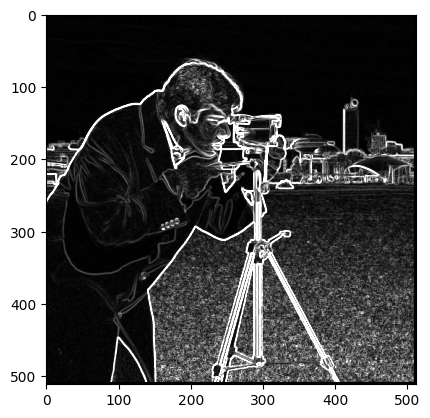

In [9]:
camera_s_hor_filter = conv(camera, sobel_kernel_hor, stride=1, pad=1)
camera_s_vert_filter = conv(camera, sobel_kernel_vert, stride=1, pad=1)
camera_with_borders = np.sqrt(camera_s_hor_filter**2 + camera_s_vert_filter**2)
plt.imshow(camera_with_borders, cmap="gray", vmin=0, vmax=255);

We amplified horizontal and vertical lines in the picture by applying Sobel operators (`sobel_kernel_vert` and `sobel_kernel_hor`, respectively). The resulted picture is an overlay of both masks with contrast borders.

## Task 2. AlexNet

Recreate the `AlexNet` architecture for plant disease detection. The datasets have already been created below.

In [10]:
INPUT_IMAGE_SIZE = 227
BATCH_SIZE = 64
N_EPOCHS = 10 # can be changed
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
from IPython.display import clear_output

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch
import os
 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [13]:
!curl -O https://storage.googleapis.com/ibeans/train.zip
!curl -O https://storage.googleapis.com/ibeans/validation.zip
!curl -O https://storage.googleapis.com/ibeans/test.zip

clear_output()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  137M    0  7568    0     0   6729      0  5:56:11  0:00:01  5:56:10  6751
  0  137M    0 82046    0     0  54051      0  0:44:20  0:00:01  0:44:19 54155
  2  137M    2 3072k    0     0  1190k      0  0:01:57  0:00:02  0:01:55 1192k
  4  137M    4 6944k    0     0  1965k      0  0:01:11  0:00:03  0:01:08 1966k
  7  137M    7 10.0M    0     0  2258k      0  0:01:02  0:00:04  0:00:58 2260k
  9  137M    9 13.3M    0     0  2481k      0  0:00:56  0:00:05  0:00:51 3114k
 12  137M   12 16.8M    0     0  2643k      0  0:00:53  0:00:06  0:00:47 3429k
 14  137M   14 19.8M    0     0  2702k      0  0:00:51  0:00:07  0:00:44 3492k
 17  137M   17 23.5M    0     0  2830k      0  0:00:49  0:00:08  0:00:41 3443k
 19  137M   19 26.5M    0     0  2862k      0  0:00

In [15]:
!tar -xf train.zip
!tar -xf validation.zip
!tar -xf test.zip

In [30]:
class BeanDataset(Dataset):
    def __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
        # image dir
        self.img_dir = img_dir
        # sorted list with file names
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # we will convert the names of folders with pictures into class numbers
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # data transformations: we change the size
        # as AlexNet works with images 227 by 227 pixels
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, normalize=True):
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # apply transformation
        if normalize:
            transformed_img = self.transforms(image)
        
        transformed_img = self._transforms_for_plot(image)
        label_name = file_path.split('\\')[-2]
        label = self.class_dir[label_name]
        
        # as usual we return the image and class number
        return transformed_img, label

In [31]:
train_dataset = BeanDataset("train/")
valid_dataset = BeanDataset("validation/")
test_dataset = BeanDataset("test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's look at our pictures:

(the code is quite esoteric, but that's what I was in the mood for)

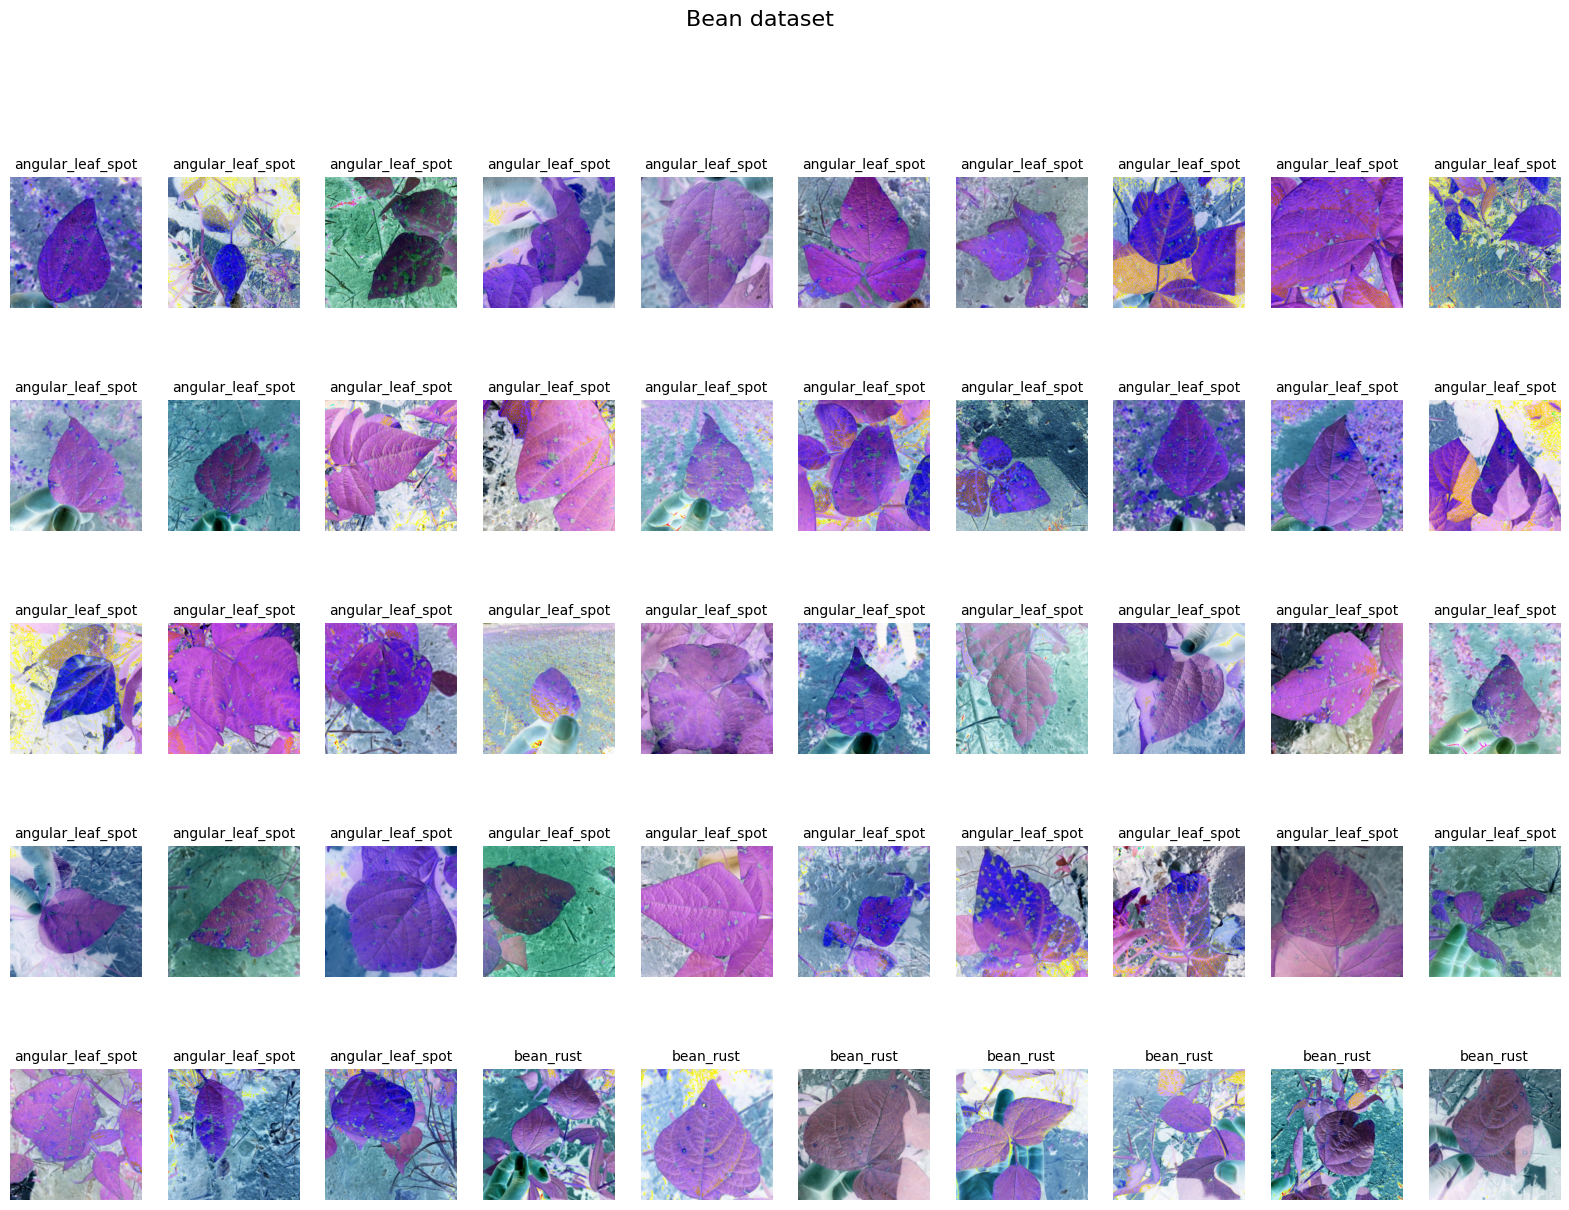

In [32]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    title = valid_dataset._number_to_labels[valid_dataset.__getitem__(index, normalize=False)[1]]
    plt.title(title, fontsize=10)
    
fig.suptitle("Bean dataset", fontsize=16);

### Implementation of `AlexNet`

In the lecture we got acquainted with the `AlexNet` architecture, now it's time to implement it ourselves. It is important that at the end the number of classes we will have is much less than 1000; we will need to determine this at the beginning. Everywhere `ReLU` is used as activation.

Also pay attention to the pooling parameters, here is a 3x3 core with stride 2 (that’s why it’s called overlapping).

The picture may be slightly different from what was shown in the lecture, refer to the picture in your laptop.

Look carefully at the convolution parameters (e.g. padding/stride).

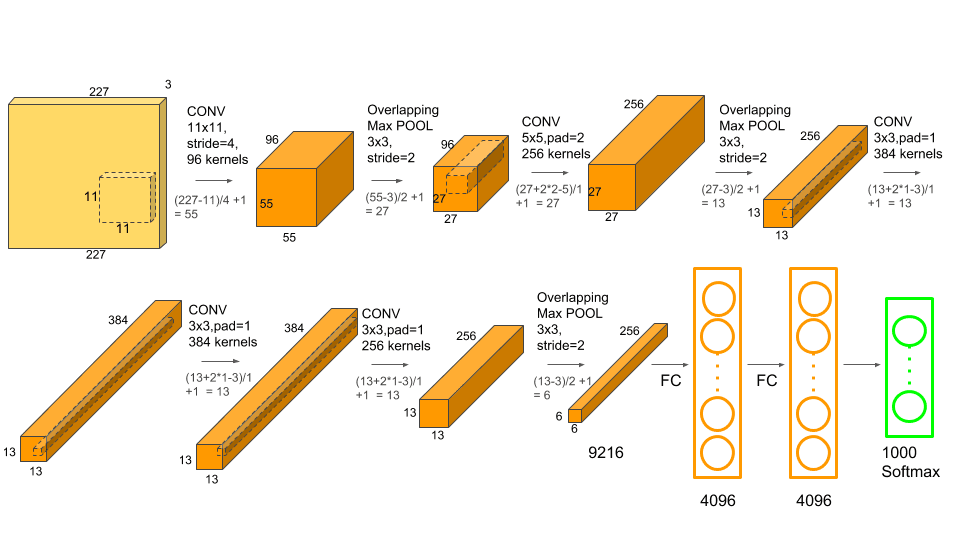

In [33]:
train_dataset.class_dir

{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}

We have 3 classes

In [34]:
N_CLASSES =  3 
LEARNING_RATE = 3e-4 

In [38]:
class AlexNet(nn.Module):
    def __init__(self, n_classes=N_CLASSES):
        super().__init__()
      
        self.n_classes = n_classes
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=9216, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=self.n_classes)
        )
            
            
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

Take the code for training and validating the model that was given in the lecture (if you want, you can change it as you like). In the lecture, we returned from the model, in addition to logits, also class probabilities, so that we could then draw beautiful pictures. If you want to do the same, please keep this in mind.

In [36]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model - 
    dataloader - 
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy


def plot_losses(train_losses, valid_losses):
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, train_losses, valid_losses

Select the loss function and optimizer and train the resulting model on the training data, while simultaneously testing it on the validation part:

In [39]:
model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # optimizer
criterion = nn.CrossEntropyLoss()  # loss function

21:30:23 --- Epoch: 0	Train loss: 1.0996	Valid loss: 1.0917	Train accuracy: 33.66	Valid accuracy: 33.83
21:33:51 --- Epoch: 1	Train loss: 1.0847	Valid loss: 1.0731	Train accuracy: 46.91	Valid accuracy: 33.83
21:36:53 --- Epoch: 2	Train loss: 1.0412	Valid loss: 0.9777	Train accuracy: 61.41	Valid accuracy: 55.64
21:39:44 --- Epoch: 3	Train loss: 0.8743	Valid loss: 1.0829	Train accuracy: 59.67	Valid accuracy: 53.38
21:42:30 --- Epoch: 4	Train loss: 0.9081	Valid loss: 0.8821	Train accuracy: 66.15	Valid accuracy: 63.91
21:45:19 --- Epoch: 5	Train loss: 0.7265	Valid loss: 0.7025	Train accuracy: 72.05	Valid accuracy: 71.43
21:48:04 --- Epoch: 6	Train loss: 0.6621	Valid loss: 0.6964	Train accuracy: 75.73	Valid accuracy: 77.44
21:50:50 --- Epoch: 7	Train loss: 0.5912	Valid loss: 0.8067	Train accuracy: 70.70	Valid accuracy: 69.92
21:53:42 --- Epoch: 8	Train loss: 0.6060	Valid loss: 0.6415	Train accuracy: 72.15	Valid accuracy: 68.42
21:56:29 --- Epoch: 9	Train loss: 0.5236	Valid loss: 0.7265	Trai

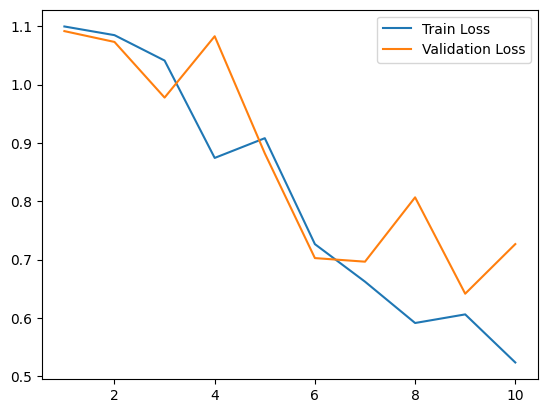

In [40]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

If you implemented everything correctly, then `accuracy` on validation should be around 0.8.

### Visualization of predictions

Let's visualize the predictions of our model and the degree of confidence in them. Draw conclusions about the quality of the resulting model.

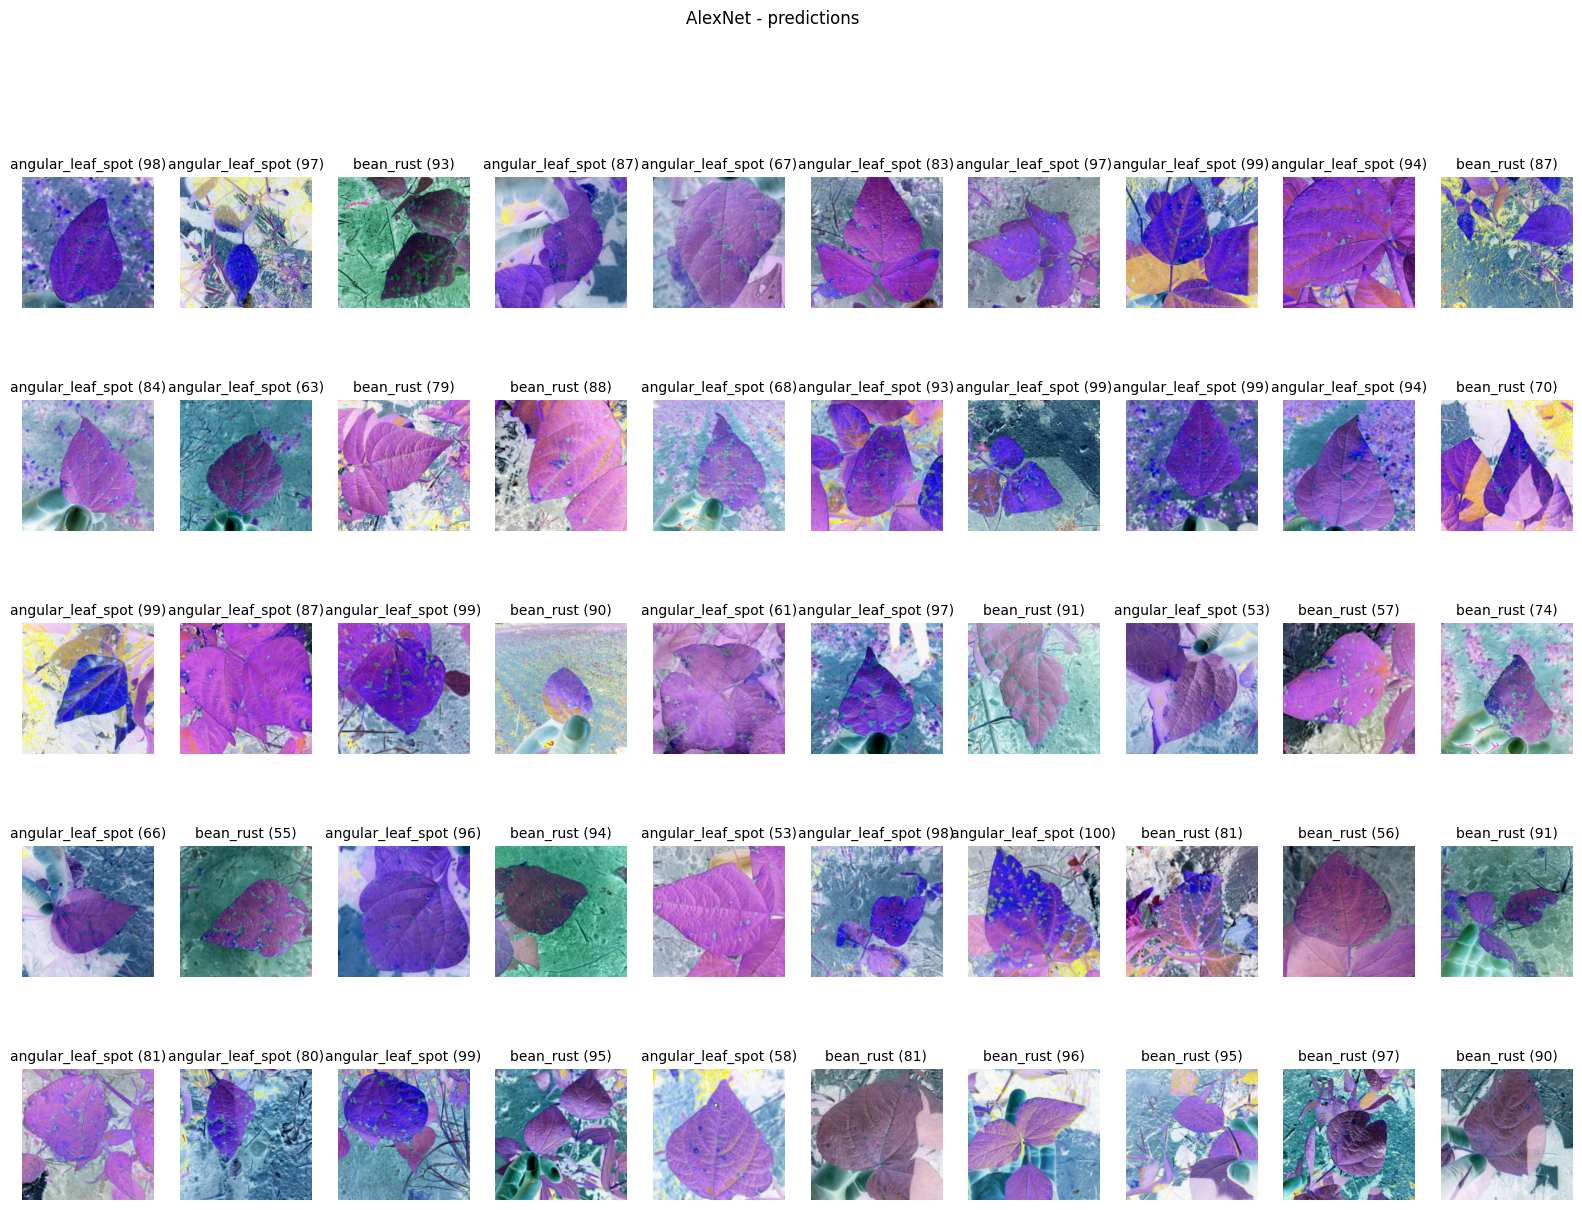

In [41]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    
    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"
    
    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');